In [8]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/examples/linear_OrnteinUhlenbeck`


In [12]:
using Revise 
using Random, Graphs, GaussianExpansionCavityMethod, SparseArrays, LinearAlgebra, Statistics
import PyPlot as plt

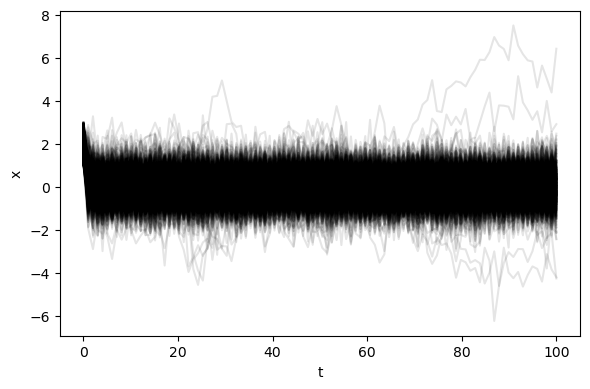

In [25]:
N, K = 1000, 4

rng = Xoshiro(1234)

lam, J, D = 2.5, 1.0/K, 1.0
Jmat = adjacency_matrix(random_regular_graph(N, K; rng=rng), Float64) 
@inbounds @fastmath for i in 1:N
    @inbounds @fastmath @simd for j in i+1:N
        if Jmat[i, j] != 0
            Jmat[i, j] = randn(rng) * sqrt(J)
            Jmat[j, i] = Jmat[i, j]
        end
    end
end
lambdas = fill(lam, N)

model = OUModel(K, Jmat, lambdas, D)

x0_min, x0_max = 1.0, 3.0
x0 = rand(rng, N) * (x0_max - x0_min) .+ x0_min
tmax = 100.0 
tsave=collect(range(0.0, tmax; length=100))

tvec, trajs = sample_OU(model, x0, tmax, tsave; rng=rng)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)
for i in 1:N
    ax.plot(tvec, view(trajs, i, :), color="k", alpha=0.1)
end
ax.set_xlabel("t")
ax.set_ylabel("x")

display(fig)

In [5]:
N, K = 1000, 4

rng = Xoshiro(1234)

lam, J, D = 2.5, 1.0/K, 1.0

x0_min, x0_max = 1.0, 3.0
dt_mc = 1e-2
tmax = 1e3
tsave = collect(range(500.0, tmax; step=dt_mc*10))

nsim = 100

# Define ensemble model
model_ensemble = OUModelRRG(N, K, J, lam, D)

# Sample ensemble
tvals_alls, traj_alls = sample_ensemble_OU(model_ensemble, x0_min, x0_max, tmax, tsave, nsim; rng=rng, showprogress=true, dt=dt_mc);

Progress: 100%|███████████████████████████| Time: 0:00:42 ( 0.43  s/it)


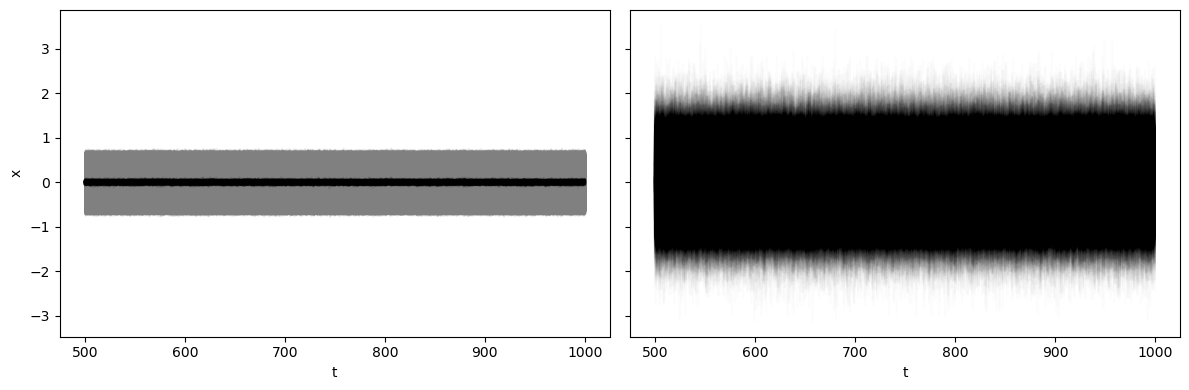

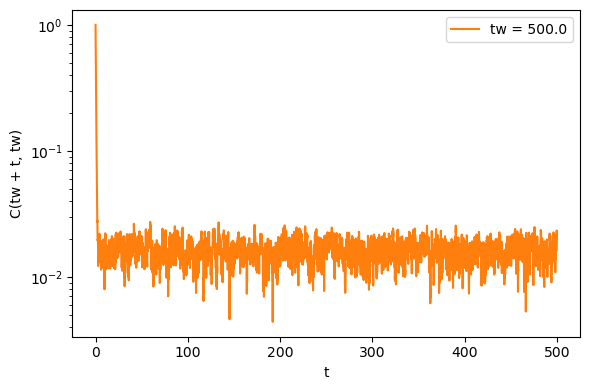

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(6*2, 4), tight_layout=true, sharey=true)
# Only averages
ax = axs[1]
mean_traj, std_traj, autocorr_traj = compute_stats(traj_alls)
ax.plot(tvals_alls[1], mean_traj, color="red")
ax.fill_between(tvals_alls[1], mean_traj .- std_traj, mean_traj .+ std_traj, color="red", alpha=0.1)
for isim in 1:nsim
    mean, std, autocorr = compute_stats(traj_alls[isim])
    ax.plot(tvals_alls[isim], mean, color="k", alpha=0.1)
    ax.fill_between(tvals_alls[isim], mean .- std, mean .+ std, color="gray", alpha=0.1)
end
ax.set_xlabel("t")
ax.set_ylabel("x")
# Method 2
ax = axs[2]
for isim in 1:nsim
    for i in 1:10
        ax.plot(tvals_alls[isim], view(traj_alls[isim],i,:), color="k", alpha=0.01)
    end
end
ax.set_xlabel("t")
plt.display(fig)

# Plotting the correlation function at different waiting times
tw_idxs = [1]#findfirst(x -> x>50, tsave)
tws = tsave[tw_idxs]
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)
autocorr_traj .+= abs(minimum(autocorr_traj))
# Plot the correlation function at different waiting times
for (i, (tw, tw_idx)) in enumerate(Iterators.zip(tws, tw_idxs))
    ax.plot(tsave[tw_idx:end] .- tw, autocorr_traj[tw_idx:end, tw_idx] ./ autocorr_traj[tw_idx, tw_idx], color="C$i", label="tw = $(round(tw, digits=0))")
end
ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlabel("t")
ax.set_ylabel("C(tw + t, tw)")
ax.legend()
plt.display(fig)

In [37]:
dt = 0.00001
T = 10000

nodes = run_cavity_EQ(model, dt, T; show_progress=true);

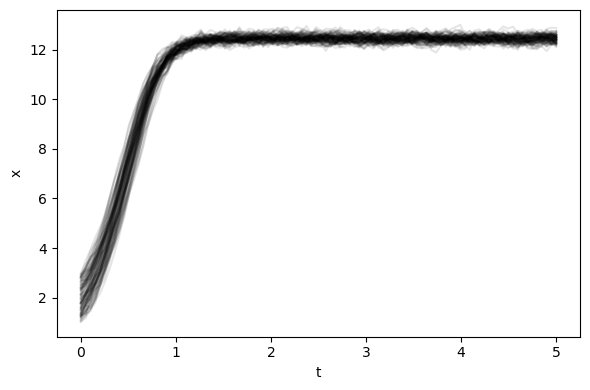

In [38]:
N, K = 100, 3

rng = Xoshiro(1234) 

J = adjacency_matrix(random_regular_graph(N, K; rng=rng)) .* 1.2 
lambda, D, u = 0.5, 0.2, 0.02

model = Phi4Model(K, J, lambda, D, u)

x0_min, x0_max = 1.0, 3.0
x0 = rand(rng, N) * (x0_max - x0_min) .+ x0_min
tmax = 5.0 
tsave=collect(range(0.0, tmax; length=100))

tvec, trajs = sample_phi4(model, x0, tmax, tsave; rng=rng)

fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=true)
for i in 1:N
    ax.plot(tvec, view(trajs, i, :), color="k", alpha=0.1)
end
ax.set_xlabel("t")
ax.set_ylabel("x")

display(fig)

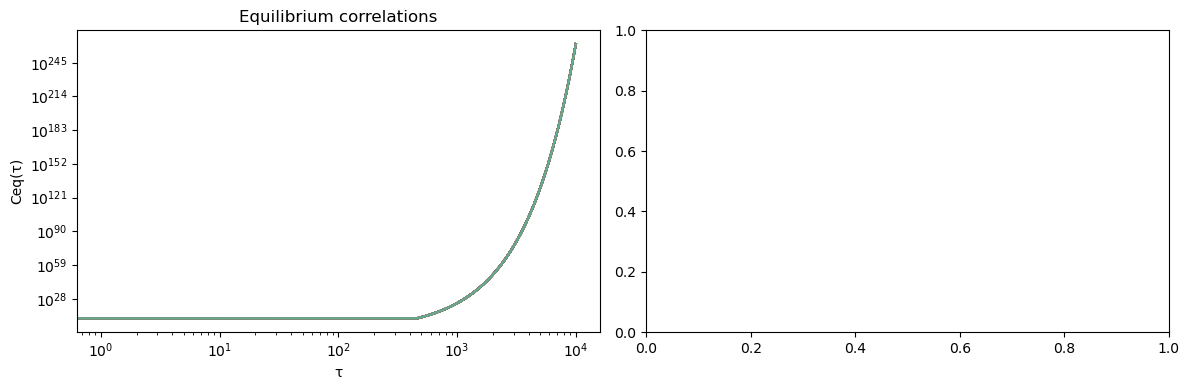

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(6*2, 4), tight_layout=true)
# Plot correlations
ax = axs[1]
for node in nodes
    ax.plot(0:T, max.(node.cavs[1].C, 1e10), alpha=0.5) 
end
ax.set_xlabel("τ")
ax.set_ylabel("Ceq(τ)")
ax.set_title("Equilibrium correlations")
ax.set_yscale("log")
ax.set_xscale("log")
#=
# Plot responses
ax = axs[2]
for node in nodes
    ax.plot(range(0, T*dt, length=T+1), node.marg.R, alpha=0.5) 
end
ax.set_xlabel("τ")
ax.set_ylabel("Req(τ)")
ax.set_title("Equilibrium responses")
ax.set_yscale("log")
ax.set_xscale("log")
=#
plt.display(fig)   

In [40]:
C, R = compute_averages(nodes, model, T);

MethodError: MethodError: no method matching compute_averages(::Vector{NodeEQ}, ::Phi4Model, ::Int64)

Closest candidates are:
  compute_averages(::Vector{NodeEQ}, !Matched::OUModel, ::Int64)
   @ GaussianExpansionCavityMethod ~/Desktop/julia_codes/GaussianExpansionCavityMethod.jl/src/linear_OrnteinUhlenbeck/utils.jl:25


In [41]:
fig, axs = plt.subplots(1, 2, figsize=(6*2, 4), tight_layout=true)
# Plot correlations
ax = axs[1]
ax.plot(range(0, T*dt, length=T+1), C)
ax.set_xlabel("τ")
ax.set_ylabel("Ceq(τ)")
ax.set_title("Equilibrium correlation")
ax.set_yscale("log")
ax.set_xscale("log")

# Plot responses
ax = axs[2]
ax.plot(range(0, T*dt, length=T+1), R)
ax.set_xlabel("τ")
ax.set_ylabel("Req(τ)")
ax.set_title("Equilibrium responses")
ax.set_yscale("log")
ax.set_xscale("log")

plt.display(fig)   

UndefVarError: UndefVarError: `C` not defined